<a href="https://colab.research.google.com/github/Ruanvans/GAN-time-series-implementation/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The following code will serve as the GAN network employed in my disseratation**

**Ruan van Schalkwyk**                                                            
**6459265**

**Supervisor: Yoachu Jin** 

**University of Surrey Computer Science** 


# **Necessary libraries and tools**

In [0]:
#libraries and tools necessary to import and visualize data
from google.colab import files
import pandas as pd
import requests 
import os
import urllib.request
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import pyplot

#libraries to create the models and visualize models
from keras.models import Sequential 
from keras.layers import Dense 
from keras.utils.vis_utils import plot_model
from numpy import hstack 
from numpy import zeros 
from numpy import ones 
from numpy.random import randn 
from numpy.random import rand
import random

# **Data Collection**

The below cells of code are used to retrieve the data used within the project from the AlphaVantage API. The first cell works directly with the API and the second cell is used to format the data into the correct format (csv file) and then downloads the data so that it can be cleaned for further use

In [0]:
Key = 'WS42XHAOBGP40QEM'
sym= 'AAPL'

fname = 'daily' + sym +'.csv'

if not os.path.isfile(fname):
  v = urllib.request.urlopen("https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=" + sym + "&apikey=" + Key + "&outputsize=full&datatype=csv").read()
  with open(fname, 'wb') as f:
    f.write(v)

In [0]:
df = pd.read_csv(fname)
df = pd.DataFrame(df)
df.to_csv('Apple.csv')
files.download('Apple.csv')
df

,timestamp,open,high,low,close,volume
0,2020-05-11,308.10,317.05,307.24,315.01,36486561
1,2020-05-08,305.64,310.35,304.29,310.13,33511985
2,2020-05-07,303.22,305.17,301.97,303.74,28803764
3,2020-05-06,300.46,303.24,298.87,300.63,35583438
4,2020-05-05,295.06,301.00,294.46,297.56,36937795
...,...,...,...,...,...,...
5027,2000-05-16,104.52,109.06,102.75,105.69,3932600
5028,2000-05-15,108.06,108.06,100.12,101.00,6061900
5029,2000-05-12,106.00,110.50,104.77,107.62,2740300
5030,2000-05-11,101.37,104.25,99.00,102.81,4462000


# **Data preprocessign**

Below cell provides convenience when uploading the data as it is faster to upload a zip file with all the cleaned data to google colab than to upload individual files. 

In [0]:
!unzip 'final_data.zip'

Archive:  final_data.zip
  inflating: boeing.csv              
  inflating: Intercontinental.csv    
  inflating: JPMorgan.csv            
  inflating: Microsoft.csv           
  inflating: pfizer.csv              


importation of the data from the cleaned csv files

In [0]:
intercontinental = pd.read_csv('Intercontinental.csv', parse_dates=True, index_col=0)
boeing = pd.read_csv('boeing.csv', parse_dates=True, index_col=0)
jpmorgan = pd.read_csv('JPMorgan.csv', parse_dates=True, index_col=0)
microsoft = pd.read_csv('Microsoft.csv', parse_dates=True, index_col=0)
pfizer = pd.read_csv('pfizer.csv', parse_dates=True, index_col=0)

# **Visualisation of the chosen stocks**

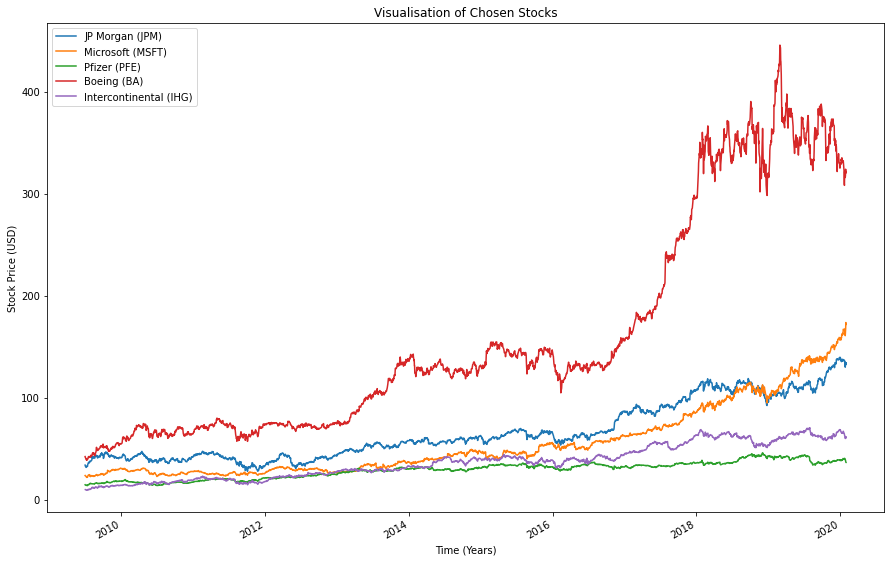

In [0]:
Intercontinental = intercontinental['open']
Boeing = boeing['open']
JPmorgan = jpmorgan['open']
Microsoft = microsoft['open']
Pfizer = pfizer['open']

plt.figure(figsize=(15,10))
JPmorgan.plot(label = 'JP Morgan (JPM)')
Microsoft.plot(label = 'Microsoft (MSFT)')
Pfizer.plot(label = 'Pfizer (PFE)')
Boeing.plot(label= 'Boeing (BA)')
Intercontinental.plot(label = 'Intercontinental (IHG)')
plt.title(label = 'Visualisation of Chosen Stocks')
plt.legend(loc='upper left')
plt.ylabel(ylabel= 'Stock Price (USD)')
plt.xlabel(xlabel= 'Time (Years)')
plt.savefig('stocks.png', bbox_inches ='tight')
files.download('stocks.png')
plt.show()

# **Vanilla GAN**

## **Creating the architecture**

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 50)                550       
_________________________________________________________________
dense_26 (Dense)             (None, 40)                2040      
_________________________________________________________________
dense_27 (Dense)             (None, 30)                1230      
_________________________________________________________________
dense_28 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_29 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 22        
Total params: 4,672
Trainable params: 4,672
Non-trainable params: 0
____________________________________________________

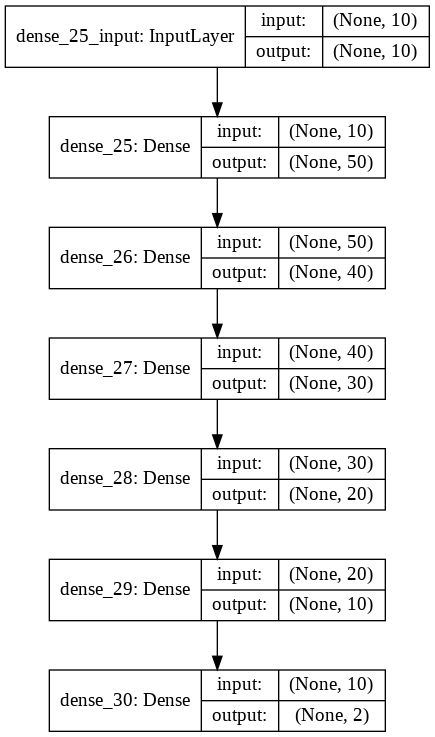

In [48]:
def Generator(latent_space, num_outputs=2):  
    model = Sequential()
    model.add(Dense(50, activation='relu', kernel_initializer='he_uniform', input_dim=latent_space))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(num_outputs, activation='linear'))
    return model

latent_space = 10
model = Generator(latent_space)
model.summary()
plot_model(model, to_file='generator_structure.png', show_shapes=True, show_layer_names=True)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 50)                150       
_________________________________________________________________
dense_32 (Dense)             (None, 40)                2040      
_________________________________________________________________
dense_33 (Dense)             (None, 30)                1230      
_________________________________________________________________
dense_34 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_35 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 11        
Total params: 4,261
Trainable params: 4,261
Non-trainable params: 0
____________________________________________________

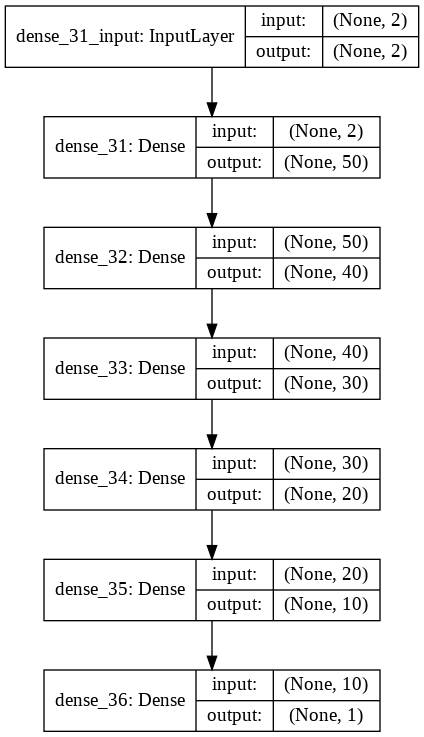

In [49]:
def Discriminator(num_inputs=2): 
    model = Sequential()
    model.add(Dense(50, activation='relu', kernel_initializer='he_uniform', input_dim=num_inputs))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = Discriminator()
model.summary()
plot_model(model, to_file='discriminator_structure.png', show_shapes=True, show_layer_names=True)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    (None, 2)                 4672      
_________________________________________________________________
sequential_9 (Sequential)    (None, 1)                 4261      
Total params: 8,933
Trainable params: 4,672
Non-trainable params: 4,261
_________________________________________________________________


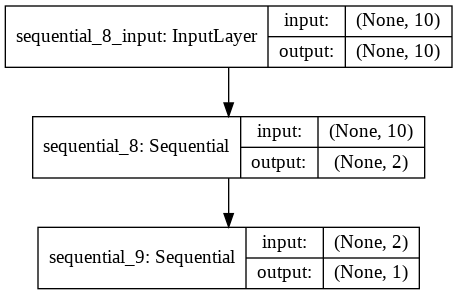

In [50]:
def GAN(Generator, Discriminator): 
    Discriminator.trainable = False
    model = Sequential()
    model.add(Generator)
    model.add(Discriminator)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model
latent_space = 10
Generator = Generator(latent_space)
Discriminator = Discriminator()

model = GAN(Generator, Discriminator)
model.summary()
plot_model(model, to_file='gan_structure.png', show_shapes=True, show_layer_names=True)

## **testing the GAN**

In [0]:
def Generate_random_numbers(n):
    for x in range(n):
      random.uniform(1,20)


In [0]:
def Real(n):
    x = generate_random_numbers(n)
    x_quartic = x ** 4

    x = x.reshape(n,1)
    x_quartic = x_quartic.reshape(n,1)

    X = hstack((x,x_quartic))

    y = ones((n,1))

    return X,y

In [0]:
def Gan_input(latent_space, n):
    generator_input = randn(latent_space *n)
    generator_input = generator_input.reshape(latent_space, n)
    return generator_input

In [0]:
def Fake(Generator, latent_space, n):
    generator_input = Gan_input(latent_space, n)

    X = Generator.predict(generator_input)
    y = zeros((n,1))

    return X,y

In [0]:
def gan_performance(epoch, latent_space, Discriminator, Generator, n=100):

    Xr, yr = Real(n) 
    Xf, yf = Fake(Generator, latent_space, n)

    _, accuracy_of_real = Descriminator.evaluate(Xr,yr, verbose =0)
    _, accuracy_of_fake = Descriminator.evaluate(Xf,yf, verbose =0)

    print(epoch +1, accuracy_of_real, accuracy_of_fake)
    plt.figure(figsize=(15,10))
    plt.scatter(Xr[:,0], Xr[:,1], color='green')
    plt.scatter(Xf[:,0], Xf[:,0], color='red')
    plt.legend(loc='upper right')
    plt.show

In [0]:
def train(GAN_model, Discriminator_model, Generator_model, latent_space, epochs=20000, batch_size= 64, eval =2500):
    half_size = int(batch_size/2)
    for i in range(epochs): 
      Xr, yr = Real(half_size)
      Xf, yf = Fake(Generator, latent_space, half_size)

      Discriminator_model.train_on_batch(Xr,yr)
      Discriminator_model.train_on_batch(Xf,yf)

      Xgan = Gan_input(latent_space, batch_size)
      ygan = ones((batch_size, 1))
      GAN_model.train_on_batch(Xgan, ygan)

      if (i+1) % eval == 0:
        gan_performance(i, latent_space, Discriminator, Generator)

In [59]:
latent_space = 10
Generator_model = Generator(latent_space)
Discriminator_model = Discriminator()
GAN_model = GAN(Generator_model, Discriminator_model)
train(GAN_model, Discriminator_model, Generator_model, latent_space)

ValueError: ignored